In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def generate_map(extent, res, square_list):
    l_per_res = extent / res
    layout = np.zeros((res, res))
    center = res / 2 + 1
    for s in square_list:
        corners = np.ndarray.astype(np.divide(vertices_square(s), l_per_res) + center, 'int')
        layout[min(corners[:, 0]):max(corners[:, 0]), min(corners[:, 1]):max(corners[:, 1])] = 1
    return np.rot90(layout)


def vertices_square(s):
    return (s['x'] + s['lx'] / 2, s['y'] + s['ly'] / 2), \
           (s['x'] - s['lx'] / 2, s['y'] + s['ly'] / 2), \
           (s['x'] - s['lx'] / 2, s['y'] - s['ly'] / 2), \
           (s['x'] + s['lx'] / 2, s['y'] - s['ly'] / 2)


def get_fft_of_image(img, plot=False):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    if plot:
        plt.subplot(121),plt.imshow(img, cmap = 'jet')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(magnitude_spectrum/np.max(magnitude_spectrum), cmap = 'jet')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    return fshift, magnitude_spectrum


def apply_filter(spectrum, fltr, plot=False):
    fshift = spectrum*fltr
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    if plot:
        plt.subplot(121),plt.imshow(20*np.log(np.abs(spectrum)), cmap = 'jet')
        plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')
        plt.title('Masked Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    return fshift, magnitude_spectrum


def get_image_from_fftfshift_lpf(fshift_lpf, plot=False):
    f_ishift = np.fft.ifftshift(fshift_lpf)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    if plot:
        plt.subplot(121),plt.imshow(img_back, cmap = 'gray')
        plt.title('Gray'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(img_back, cmap = 'jet')
        plt.title('Jet'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    return img_back
    
def laplas_filter(rows, cols):
    mask_laplas = np.zeros((rows,cols), dtype=np.float32)
    for u in range(rows):
        for v in range(cols):
            mask_laplas[u,v] = 4*np.pi*np.pi*((u-rows/2)**2 + (v-cols/2)**2)
    mask_laplas = mask_laplas / np.max(mask_laplas)
    
    return mask_laplas


def gaussian_filter(rows, cols, sigma=[1,1], mu=[0,0]):
    sigma = [sigma[0]*rows, sigma[1]*cols]
    mu = [mu[0]+rows/2, mu[1]+cols/2]
    mask_gauss = np.zeros((rows,cols), dtype=np.float32)
    for u in range(rows):
        for v in range(cols):
            mask_gauss[u,v] = np.exp(-(((u-mu[0])**2/(2*sigma[0]**2))+((v-mu[1])**2/(2*sigma[1]**2))))
    return mask_gauss

In [3]:
square1 = {'x': 0,
           'y': 0,
           'lx': 1,
           'ly': 8}
square2 = {'x': 0.85,
           'y': 0,
           'lx': 0.1,
           'ly': 8}

square3 = {'x': -0.85,
           'y': 0,
           'lx': 0.1,
           'ly': 8}
extent = 10
res = 128

In [4]:
layout1 = generate_map(extent, res, [square1])

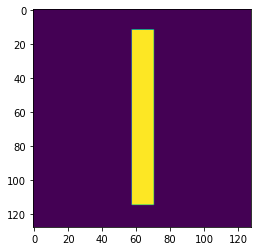

In [5]:
img = Image.fromarray(layout1*255)
# img.show()
plt.imshow(layout1)

## FFT of Image using numpy

### Low pass filter

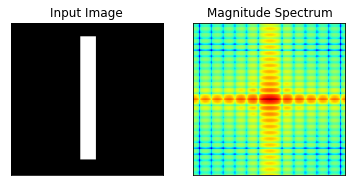

<ipython-input-2-3ec45e01cadb>:34: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
<ipython-input-2-3ec45e01cadb>:38: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')


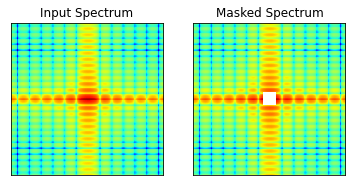

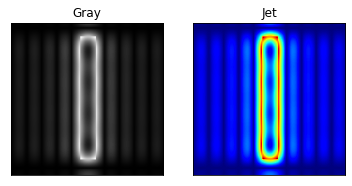

In [9]:
rows, cols = img.size
crow,ccol = int(rows/2) , int(cols/2)
mask = np.ones((rows,cols),np.uint8)
k = 5
mask[crow-k:crow+k, ccol-k:ccol+k] = 0

fshift, mag_spectrum = get_fft_of_image(img, plot=True)
# fshift, mag_spectrum = get_fft_of_image(mag_spectrum)
fshift, magnitude_spectrum = apply_filter(fshift, mask, plot=True)
img_back = get_image_from_fftfshift_lpf(fshift, plot=True)

255.0

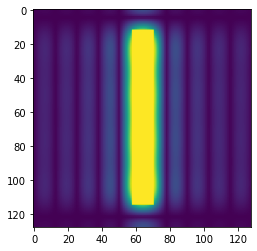

In [10]:
norm_img = (img_back/np.max(img_back))*255

plt.imshow((norm_img > 0.2).astype(int))
# plt.imshow(img)
img_ord = img+norm_img
img_ord = np.clip(img_ord,0,255)
plt.imshow(img_ord)
np.max(img_ord)

In [11]:
rows, cols = img.size
crow,ccol = int(rows/2) , int(cols/2)
mask = np.zeros((rows,cols),np.uint8)
kx = 3
ky = 3
mask[crow-kx:crow+kx, ccol-ky:ccol+ky] = 1
fshift, mag_spectrum = get_fft_of_image(img_ord)
fshift, magnitude_spectrum = apply_filter(fshift, mask)
get_image_from_fftfshift_lpf(fshift)

<ipython-input-2-3ec45e01cadb>:34: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))


array([[3.06421266, 3.19310016, 3.50684023, ..., 3.84489329, 3.43263274,
        3.15195049],
       [3.24006161, 3.38762475, 3.71949507, ..., 3.99032516, 3.58118492,
        3.31119759],
       [3.52337426, 3.68590218, 4.03551786, ..., 4.26300274, 3.84969778,
        3.5837079 ],
       ...,
       [3.24006161, 3.31119759, 3.58118492, ..., 4.17162347, 3.71949507,
        3.38762475],
       [3.06421266, 3.15195049, 3.43263274, ..., 3.94180886, 3.50684023,
        3.19310016],
       [3.00447281, 3.11248894, 3.40855496, ..., 3.82989622, 3.40855496,
        3.11248894]])

In [12]:
rows, cols = img.size
crow,ccol = int(rows/2) , int(cols/2)
mask = np.zeros((rows,cols),np.uint8)
kx = 3
ky = 3
mask[crow-kx:crow+kx, ccol-ky:ccol+ky] = 1
fshift, mag_spectrum = get_fft_of_image(img)
fshift, magnitude_spectrum = apply_filter(fshift, mask)
get_image_from_fftfshift_lpf(fshift)

<ipython-input-2-3ec45e01cadb>:34: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))


array([[0.050108  , 0.14543923, 0.27491531, ..., 0.40175285, 0.27491531,
        0.14543923],
       [0.06767464, 0.19642667, 0.37129391, ..., 0.54259759, 0.37129391,
        0.19642667],
       [0.09179784, 0.26644462, 0.50364477, ..., 0.7360111 , 0.50364477,
        0.26644462],
       ...,
       [0.06767464, 0.19642667, 0.37129391, ..., 0.54259759, 0.37129391,
        0.19642667],
       [0.050108  , 0.14543923, 0.27491531, ..., 0.40175285, 0.27491531,
        0.14543923],
       [0.04314786, 0.12523731, 0.23672881, ..., 0.34594826, 0.23672881,
        0.12523731]])

### Laplacian FIlter

1.0

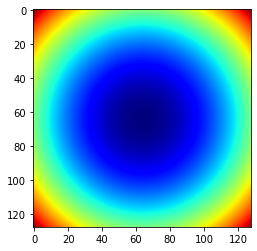

In [8]:
mask_laplas = laplas_filter(rows,cols)

plt.imshow(mask_laplas, cmap = 'jet')
np.max(mask_laplas)

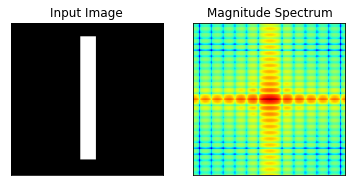

<ipython-input-2-21a2c7195590>:33: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
<ipython-input-2-21a2c7195590>:37: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')


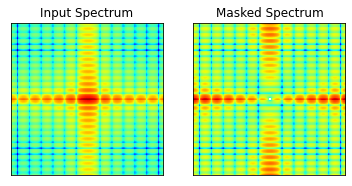

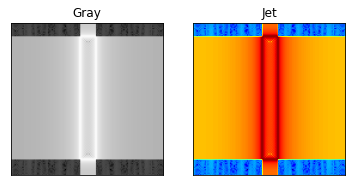

In [9]:
fshift, mag_spectrum = get_fft_of_image(img)
fshift, magnitude_spectrum = apply_filter(fshift, mask_laplas)
get_image_from_fftfshift_lpf(fshift)

### Gaussian

0.0 1.0


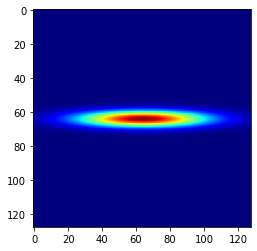

In [10]:
mask_gauss = gaussian_filter(rows,cols,sigma=[0.025,0.2])

plt.imshow(mask_gauss, cmap = 'jet')
print(np.min(mask_gauss), np.max(mask_gauss))


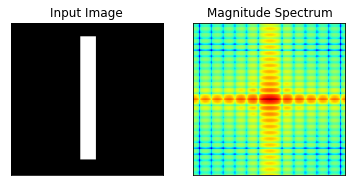

<ipython-input-2-21a2c7195590>:33: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
<ipython-input-2-21a2c7195590>:37: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')


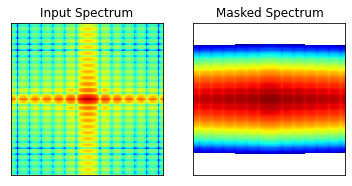

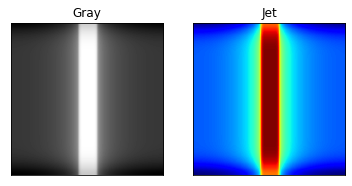

In [11]:
fshift, mag_spectrum = get_fft_of_image(img)
fshift, magnitude_spectrum = apply_filter(fshift, mask_gauss)
get_image_from_fftfshift_lpf(fshift)

In [8]:
square1 = {'x': 0,'y': 0,'lx': 1,'ly': 8}
square2 = {'x': 0.5+1.5*0.5,'y': 0,'lx': 0.2,'ly': 8}
square3 = {'x': -(0.5+1.5*0.5),'y': 0,'lx': 0.2,'ly': 8}
extent = 10
res = 128

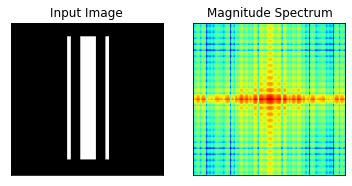

<ipython-input-2-3ec45e01cadb>:34: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
<ipython-input-2-3ec45e01cadb>:38: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')


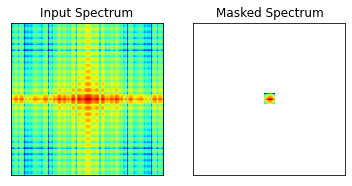

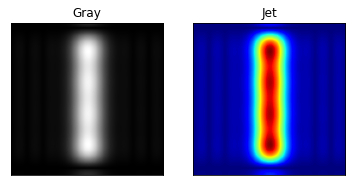

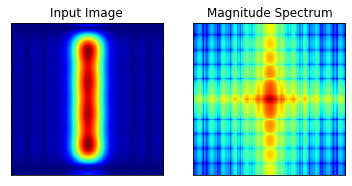

In [9]:
layout1 = generate_map(extent, res, [square1, square2, square3])
img = Image.fromarray(layout1*255)
rows, cols = img.size
crow,ccol = int(rows/2) , int(cols/2)
mask = np.zeros((rows,cols),np.uint8)
kx = 5
ky = 5
mask[crow-kx:crow+kx, ccol-ky:ccol+ky] = 1
fshift, mag_spectrum = get_fft_of_image(img, plot=True)
fshift, magnitude_spectrum = apply_filter(fshift, mask, plot=True)
get_image_from_fftfshift_lpf(fshift)
outi = get_image_from_fftfshift_lpf(fshift, plot=True)
fshift, mag_spectrum = get_fft_of_image(outi, plot=True)

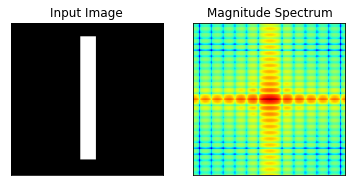

<ipython-input-2-3ec45e01cadb>:34: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
<ipython-input-2-3ec45e01cadb>:38: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(20*np.log(np.abs(fshift)), cmap = 'jet')


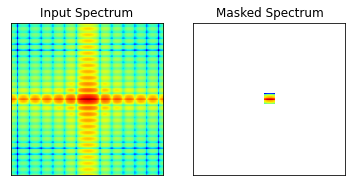

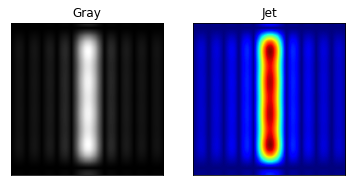

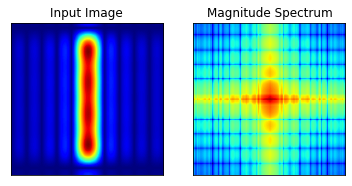

In [7]:
layout1 = generate_map(extent, res, [square1])
img = Image.fromarray(layout1*255)

fshift, mag_spectrum = get_fft_of_image(img, plot=True)
fshift, magnitude_spectrum = apply_filter(fshift, mask, plot=True)
outi = get_image_from_fftfshift_lpf(fshift, plot=True)
fshift, mag_spectrum = get_fft_of_image(outi, plot=True)

In [92]:
np.max(img)

255.0